311 569


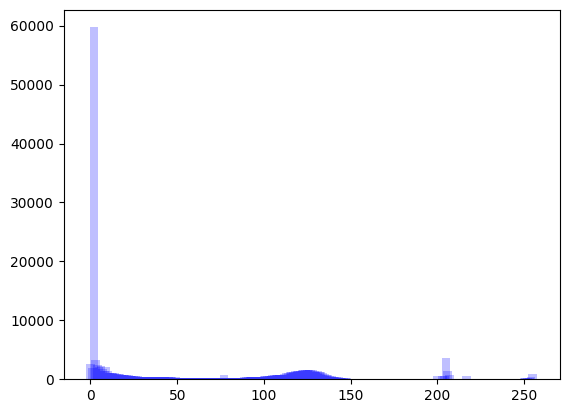

optimal threshold 75


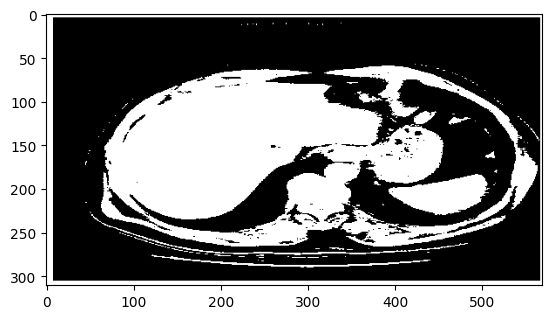

In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import cv2

threshold_values = {}
h = [1]

def Hist(img):
    row, col = img.shape 
    print(row, col)
    y = np.zeros(256)
    for i in range(0, row):
        for j in range(0, col):
            y[img[i, j]] += 1
    x = np.arange(0, 256)
    plt.bar(x, y, color='b', width=5, align='center', alpha=0.25)
    plt.show()
    return y

def regenerate_img(img, threshold):
    row, col = img.shape 
    y = np.zeros((row, col))
    for i in range(0, row):
        for j in range(0, col):
            if img[i, j] >= threshold:
                y[i, j] = 255
            else:
                y[i, j] = 0
    return y

def countPixel(h):
    cnt = 0
    for i in range(0, len(h)):
        if h[i] > 0:
            cnt += h[i]
    return cnt

def weight(s, e):
    w = 0
    for i in range(s, e):
        w += h[i]
    return w

def mean(s, e):
    m = 0
    w = weight(s, e)
    for i in range(s, e):
        m += h[i] * i
    return m / float(w)

def variance(s, e):
    v = 0
    m = mean(s, e)
    w = weight(s, e)
    for i in range(s, e):
        v += ((i - m) ** 2) * h[i]
    v /= w
    return v

def threshold(h):
    cnt = countPixel(h)
    for i in range(1, len(h)):
        vb = variance(0, i)
        wb = weight(0, i) / float(cnt)
        mb = mean(0, i)
        
        vf = variance(i, len(h))
        wf = weight(i, len(h)) / float(cnt)
        mf = mean(i, len(h))
        
        V2w = wb * (vb) + wf * (vf)
        V2b = wb * wf * (mb - mf) ** 2
        
        with open("trace.txt", "a") as fw:
            fw.write('T=' + str(i) + "\n")
            fw.write('Wb=' + str(wb) + "\n")
            fw.write('Mb=' + str(mb) + "\n")
            fw.write('Vb=' + str(vb) + "\n")
            fw.write('Wf=' + str(wf) + "\n")
            fw.write('Mf=' + str(mf) + "\n")
            fw.write('Vf=' + str(vf) + "\n")
            fw.write('within class variance=' + str(V2w) + "\n")
            fw.write('between class variance=' + str(V2b) + "\n")
            fw.write("\n")
        
        if not math.isnan(V2w):
            threshold_values[i] = V2w

def get_optimal_threshold():
    min_V2w = min(threshold_values.values())
    optimal_threshold = [k for k, v in threshold_values.items() if v == min_V2w]
    print('optimal threshold', optimal_threshold[0])
    return optimal_threshold[0]

try:
    image_path = 'img.jpg'  # Update this path to the correct location
    image = Image.open(image_path).convert("L")
    img = np.asarray(image)

    h = Hist(img)
    threshold(h)
    op_thres = get_optimal_threshold()

    res = regenerate_img(img, op_thres)
    plt.imshow(res, cmap='gray')
    plt.savefig("otsu.jpg")
except FileNotFoundError as e:
    print(f"Error: {e}")


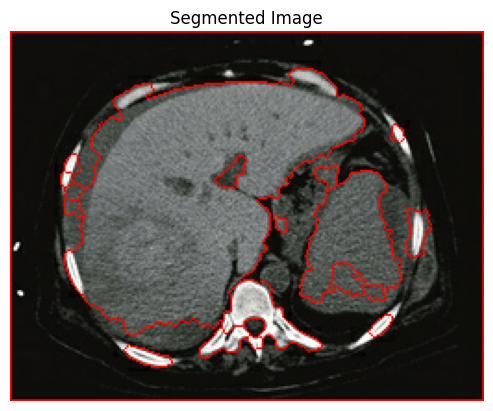

In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

# Function to display image using matplotlib
def im(image, title="Image"):
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load the image
image_path = "test.jpg"  # Replace with your image path
img = cv.imread(image_path, 1)

# Check if the image was loaded correctly
if img is None:
    print(f"Error: Could not load image at {image_path}")
else:
    # Convert to grayscale and apply Otsu's thresholding
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    th1 = 0
    th2 = 255
    ret, thresh = cv.threshold(gray, th1, th2, cv.THRESH_BINARY + cv.THRESH_OTSU)

    # Noise removal
    kernel = np.ones((3, 3), np.uint8)
    opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=2)

    # Sure background area
    sure_bg = cv.dilate(opening, kernel, iterations=3)

    # Defining accuracy
    acc = 0.01

    # Finding sure foreground area
    dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)
    ret, sure_fg = cv.threshold(dist_transform, acc * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract(sure_bg, sure_fg)

    # Marker labelling
    ret, markers = cv.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0
    markers = cv.watershed(img, markers)
    img[markers == -1] = [0, 0, 255]

    # Save and display the segmentation result
    cv.imwrite("segmentation.jpg", img)
    im(img, title="Segmented Image")

    # Wait for a key press and close windows
    cv.waitKey(0)
    cv.destroyAllWindows()


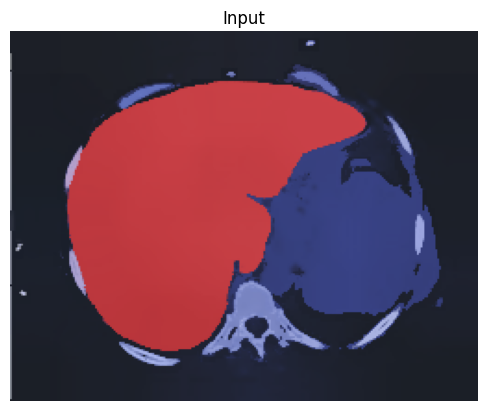

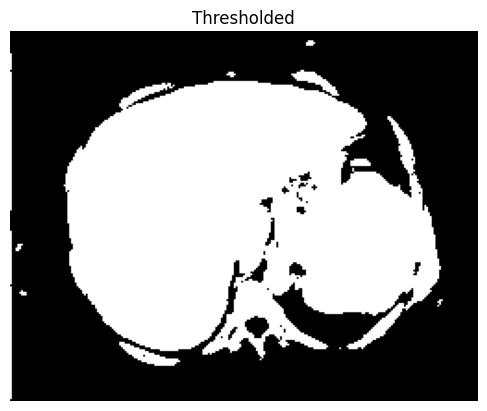

[INFO] 2 unique segments found


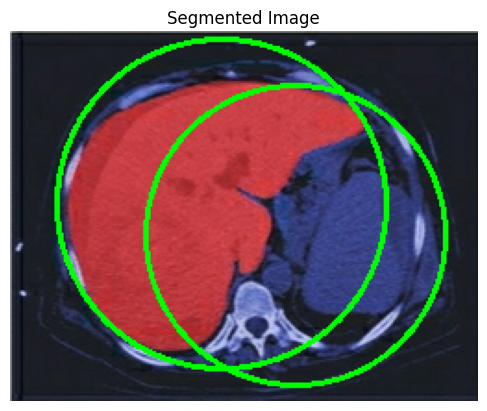

In [3]:
# Import the necessary packages
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

# Function to display image using matplotlib
def im(image, title="Image"):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load the image and perform pyramid mean shift filtering
image_path = "gt.jpg"  # Replace with your image path
image = cv2.imread(image_path)

# Check if the image was loaded correctly
if image is None:
    print(f"Error: Could not load image at {image_path}")
else:
    shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)
    im(shifted, title="Input")

    # Convert the mean shift image to grayscale, then apply Otsu's thresholding
    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    im(thresh, title="Thresholded")

    # Compute the exact Euclidean distance from every binary pixel to the nearest zero pixel, then find peaks in this distance map
    D = ndimage.distance_transform_edt(thresh)
    localMax = peak_local_max(D, min_distance=20, labels=thresh)

    # Perform a connected component analysis on the local peaks, using 8-connectivity, then apply the Watershed algorithm with active contours
    markers, _ = ndimage.label(localMax, structure=np.ones((3, 3)))
    markers = np.zeros_like(D, dtype=int)
    markers[localMax[:, 0], localMax[:, 1]] = np.arange(len(localMax)) + 1
    labels = watershed(-D, markers, mask=thresh)
    print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

    # Loop over the unique labels returned by the Watershed algorithm
    for label in np.unique(labels):
        # If the label is zero, we are examining the 'background' so simply ignore it
        if label == 0:
            continue

        # Otherwise, allocate memory for the label region and draw it on the mask
        mask = np.zeros(gray.shape, dtype="uint8")
        mask[labels == label] = 255

        # Detect contours in the mask and grab the largest one
        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # Draw a circle enclosing the object
        ((x, y), r) = cv2.minEnclosingCircle(c)
        cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)

    # Show the output image
    im(image, title="Segmented Image")
    cv2.imwrite("contour.jpg", image)


In [14]:
import numpy as np
import cv2
from PIL import Image
k=1

# segmentation
seg = Image.open('segmentation.jpg').convert("L")
seg = np.asarray(seg)
 
# ground truth
gt = Image.open('gt.jpg').convert("L")
gt = np.asarray(seg)

dice = np.sum(seg[gt==k])*2.0 / (np.sum(seg) + np.sum(gt))

print("Dice similarity score is {}".format(dice))

Dice similarity score is 5.050991442273566e-06


In [17]:
import numpy as np
import cv2
from PIL import Image
k=1

# segmentation
seg = Image.open('contour.jpg').convert("L")
seg = np.asarray(seg)
 
# ground truth
gt = Image.open('gt.jpg').convert("L")
gt = np.asarray(seg)

dice = np.sum(seg[gt==k])*2.0 / (np.sum(seg) + np.sum(gt))

print("Dice similarity score is {}".format(dice))

Dice similarity score is 0.0


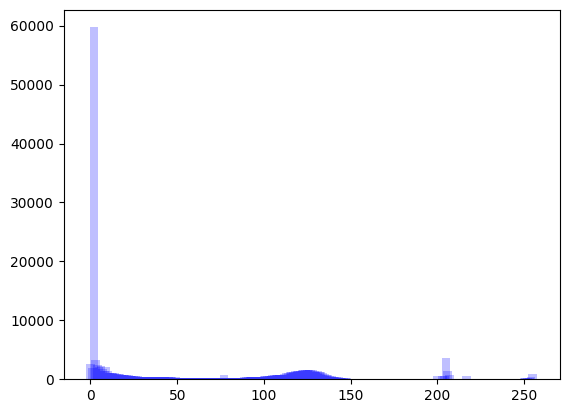

optimal threshold 75
[INFO] 4 unique segments found


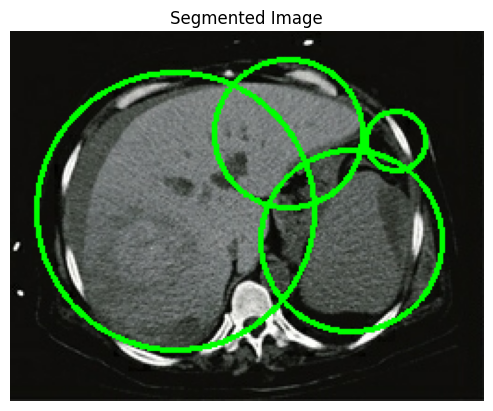

IndexError: boolean index did not match indexed array along dimension 1; dimension is 256 but corresponding boolean dimension is 253

In [19]:
import math
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import cv2
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import imutils

threshold_values = {}

def Hist(img):
    row, col = img.shape 
    y = np.zeros(256)
    for i in range(0, row):
        for j in range(0, col):
            y[img[i, j]] += 1
    x = np.arange(0, 256)
    plt.bar(x, y, color='b', width=5, align='center', alpha=0.25)
    plt.show()
    return y

def regenerate_img(img, threshold):
    row, col = img.shape 
    y = np.zeros((row, col))
    for i in range(0, row):
        for j in range(0, col):
            if img[i, j] >= threshold:
                y[i, j] = 255
            else:
                y[i, j] = 0
    return y

def countPixel(h):
    cnt = 0
    for i in range(0, len(h)):
        if h[i] > 0:
            cnt += h[i]
    return cnt

def weight(h, s, e):
    w = 0
    for i in range(s, e):
        w += h[i]
    return w

def mean(h, s, e):
    m = 0
    w = weight(h, s, e)
    for i in range(s, e):
        m += h[i] * i
    return m / float(w)

def variance(h, s, e):
    v = 0
    m = mean(h, s, e)
    w = weight(h, s, e)
    for i in range(s, e):
        v += ((i - m) ** 2) * h[i]
    v /= w
    return v

def threshold(h):
    cnt = countPixel(h)
    for i in range(1, len(h)):
        vb = variance(h, 0, i)
        wb = weight(h, 0, i) / float(cnt)
        mb = mean(h, 0, i)
        
        vf = variance(h, i, len(h))
        wf = weight(h, i, len(h)) / float(cnt)
        mf = mean(h, i, len(h))
        
        V2w = wb * (vb) + wf * (vf)
        V2b = wb * wf * (mb - mf) ** 2
        
        with open("trace.txt", "a") as fw:
            fw.write('T=' + str(i) + "\n")
            fw.write('Wb=' + str(wb) + "\n")
            fw.write('Mb=' + str(mb) + "\n")
            fw.write('Vb=' + str(vb) + "\n")
            fw.write('Wf=' + str(wf) + "\n")
            fw.write('Mf=' + str(mf) + "\n")
            fw.write('Vf=' + str(vf) + "\n")
            fw.write('within class variance=' + str(V2w) + "\n")
            fw.write('between class variance=' + str(V2b) + "\n")
            fw.write("\n")
        
        if not math.isnan(V2w):
            threshold_values[i] = V2w

def get_optimal_threshold():
    min_V2w = min(threshold_values.values())
    optimal_threshold = [k for k, v in threshold_values.items() if v == min_V2w]
    print('optimal threshold', optimal_threshold[0])
    return optimal_threshold[0]

def im(image, title="Image"):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

def otsu_segmentation(image_path):
    image = Image.open(image_path).convert("L")
    img = np.asarray(image)

    h = Hist(img)
    threshold(h)
    op_thres = get_optimal_threshold()

    res = regenerate_img(img, op_thres)
    plt.imshow(res, cmap='gray')
    plt.savefig("otsu.jpg")

def watershed_segmentation(image_path, output_path):
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return

    shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)
    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    D = ndimage.distance_transform_edt(thresh)
    localMax = peak_local_max(D, min_distance=20, labels=thresh)

    markers, _ = ndimage.label(localMax, structure=np.ones((3, 3)))
    markers = np.zeros_like(D, dtype=int)
    markers[localMax[:, 0], localMax[:, 1]] = np.arange(len(localMax)) + 1
    labels = watershed(-D, markers, mask=thresh)
    print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

    for label in np.unique(labels):
        if label == 0:
            continue

        mask = np.zeros(gray.shape, dtype="uint8")
        mask[labels == label] = 255

        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        ((x, y), r) = cv2.minEnclosingCircle(c)
        cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)

    im(image, title="Segmented Image")
    cv2.imwrite(output_path, image)

def calculate_dice(segmentation_path, ground_truth_path):
    seg = Image.open(segmentation_path).convert("L")
    seg = np.asarray(seg)

    gt = Image.open(ground_truth_path).convert("L")
    gt = np.asarray(gt)

    # Ensure dimensions match by resizing ground truth to segmentation dimensions
    if seg.shape != gt.shape:
        gt = cv2.resize(gt, (seg.shape[1], seg.shape[0]))

    dice = np.sum(seg[gt==1])*2.0 / (np.sum(seg) + np.sum(gt))
    print("Dice similarity score is {}".format(dice))

try:
    # Perform Otsu's thresholding and save result
    otsu_image_path = 'img.jpg'  # Update this path to the correct location
    otsu_segmentation(otsu_image_path)

    # Perform watershed segmentation and save result
    segmentation_image_path = 'test.jpg'  # Update this path to the correct location
    watershed_output_path = 'segmentation.jpg'
    watershed_segmentation(segmentation_image_path, watershed_output_path)

    # Calculate Dice similarity score
    ground_truth_path = 'gt.jpg'  # Update this path to the correct location
    calculate_dice(watershed_output_path, ground_truth_path)
except FileNotFoundError as e:
    print(f"Error: {e}")
